# Custom Embeddings

Using embeddings out of the box can result in a poor performance. It is often useful to train custom embeddings for a use case. 
This requires labels or taking a dataset from the domain that already has labels, but can be well worth it.

Inspired by this tweet:
https://twitter.com/sergeykarayev/status/1679172757722988544

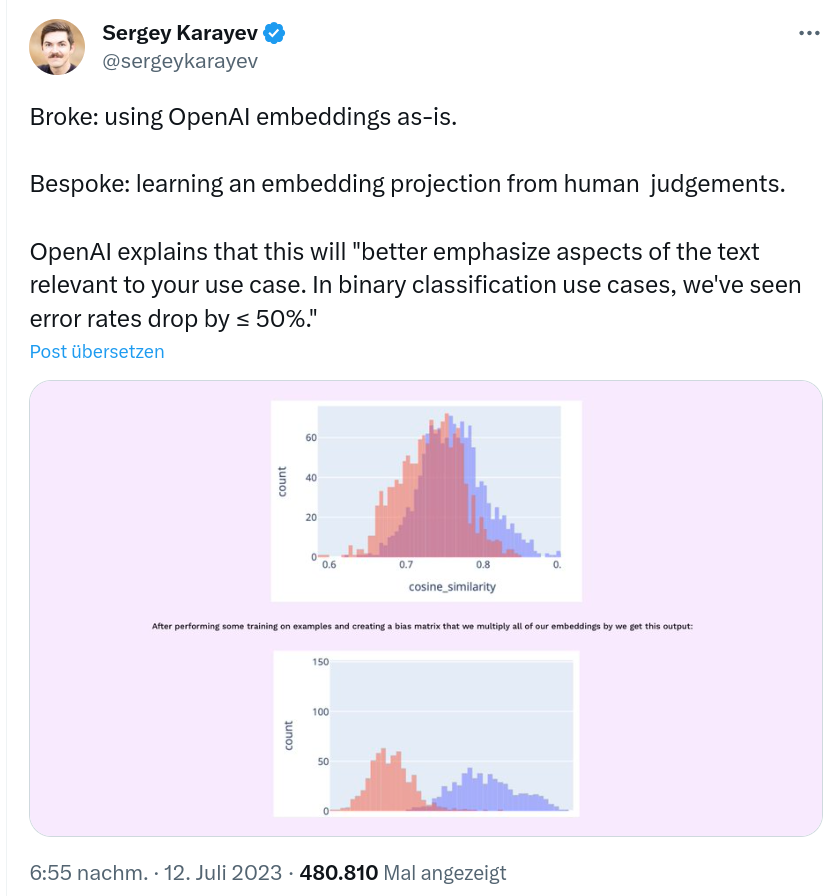

OpenAi also writes how it can be useful to further train embeddings: https://github.com/openai/openai-cookbook/blob/main/examples/Customizing_embeddings.ipynb

This notebook shows how using publicly available data.

In [1]:
import torch
import numpy as np
import pandas as pd

In [2]:
import random

def set_seed(seed=42):
    random.seed(seed)               # Python
    np.random.seed(seed)            # Numpy
    torch.manual_seed(seed)         # PyTorch CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)       # PyTorch CUDA
        torch.cuda.manual_seed_all(seed)   # PyTorch all GPUs
        torch.backends.cudnn.deterministic = True  # CUDNN
        torch.backends.cudnn.benchmark = False

set_seed(42)

## Read data

I am using as an example data set the U.S. Patent Phrase to Phrase Matching. We are trying to match phrases to patent documents. The data is available here: https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching

In [3]:
df = pd.read_csv("~/Downloads/us-patent-phrase-to-phrase-matching/train.csv")
df.head(),len(df)

(                 id     anchor                  target context  score
 0  37d61fd2272659b1  abatement  abatement of pollution     A47   0.50
 1  7b9652b17b68b7a4  abatement          act of abating     A47   0.75
 2  36d72442aefd8232  abatement         active catalyst     A47   0.25
 3  5296b0c19e1ce60e  abatement     eliminating process     A47   0.50
 4  54c1e3b9184cb5b6  abatement           forest region     A47   0.00,
 36473)

## Preprocess: Get embeddings
Here you can use any embedding model to embed your text

In [4]:
from openai import Embedding
from typing import List

from tenacity import retry, stop_after_attempt, wait_random_exponential

# copied from openai since they have bigger dependencies in this file that I dont need 
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_embeddings(
    list_of_text: List[str], engine="text-similarity-babbage-001", **kwargs
) -> List[List[float]]:
    assert len(list_of_text) <= 2048, "The batch size should not be larger than 2048."

    # replace newlines, which can negatively affect performance.
    list_of_text = [text.replace("\n", " ") for text in list_of_text]

    data = Embedding.create(input=list_of_text, engine=engine, **kwargs).data
    return [d["embedding"] for d in data]



In [5]:
import pickle
import os
from pathlib import Path

import openai
from tqdm.notebook import tqdm
import dotenv
dotenv.load_dotenv()


max_batch_size=2048

for col in ["anchor","target"]:
    cache = f'data/{col}.pickle'
    if Path(cache).exists():
        embeddings = pickle.load(open(cache,"rb"))
    else:
        # sign up with openai and generate a key. creating the embeddings costs 5 cents in August 2023
        # put your openai key in the a .env file in your repo root 
        openai.api_key = os.environ["OPEN_AI_KEY"]
        embeddings= []
        for i in tqdm(range(0,len(df),max_batch_size),total=len(df)//max_batch_size):
            texts= df[col].iloc[i:i+max_batch_size]
            embeddings.extend(get_embeddings(texts,engine="text-embedding-ada-002"))

        with open(cache, 'wb') as f:
            pickle.dump(embeddings, f)
    df[col+"_embeddings"]=embeddings


In [6]:
eval_df= df.sample(3000, random_state=1).reset_index()
df =df.iloc[~df.index.isin(eval_df.index)].reset_index()
len(df),len(eval_df)

(33473, 3000)

## Baseline: Embedding cosine similarity


In [7]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [8]:
df["cosine_sim"]=df.apply(lambda x: cosine_similarity(x["anchor_embeddings"],x["target_embeddings"]),axis=1 )

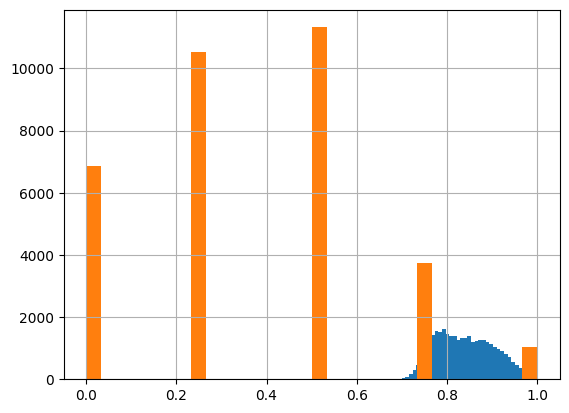

In [9]:
## compare target and actual
df.cosine_sim.hist(bins=40)
df.score.hist(bins=30);

# we see cosine clumps around 0.8, it is already interesting that most combinations have a somewhat high cosine similarity

### Confirm problem observed in tweet

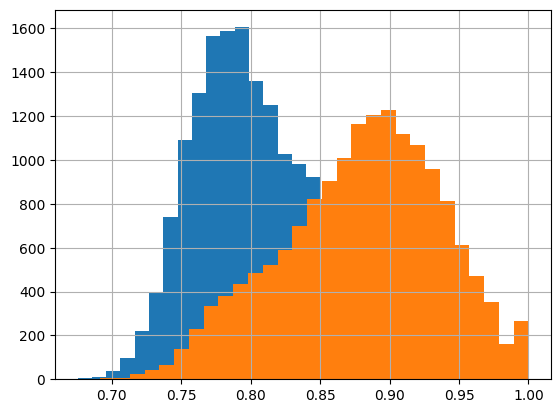

In [10]:
df.groupby(df.score>=0.5).cosine_sim.hist(bins=30);
# we see that the cosine similartiy is higher for higher scores, but it is not splitting similar and dissimilar well
# -> we confirm the problem observed in the tweet. Out of the box embeddings from openai will not serve us well
# when using cosine similarity

In [11]:
def mean_abs_error():
    return (df.cosine_sim-df.score).abs().mean()

mean_abs_error().round(2) # average error 0.5

0.48

In [12]:
from scipy import stats

stats.pearsonr(df.cosine_sim, df.score) 
# pearson score is used as an evaluation metric for this challenge

PearsonRResult(statistic=0.5901750160313239, pvalue=0.0)

## Train embeddings using plain pytorch

In [13]:
e1 = np.stack(np.array(df["anchor_embeddings"].values))
e1 = torch.from_numpy(e1).float()
e1.shape

torch.Size([33473, 1536])

In [14]:
e1 = torch.tensor(df.anchor_embeddings,dtype=torch.float32)
e2 = torch.tensor(df.target_embeddings,dtype=torch.float32)
target= torch.tensor(df.score,dtype=torch.float32)

dataset = torch.utils.data.TensorDataset(e1, e2, target)

In [77]:
def model(embedding_1, embedding_2, matrix, dropout_perc=0):
    e1 = torch.nn.functional.dropout(embedding_1,dropout_perc)
    e2 = torch.nn.functional.dropout(embedding_2,dropout_perc)
    modified_embedding_1 = e1@ matrix  # @ is matrix multiplication
    modified_embedding_2 = e2@ matrix  # TODO: seperate embedding matrix for queries?
    # adding one non-linearity to the model improves it a lot. the sample notebook only adds a linear transformation
    modified_embedding_1= torch.nn.functional.relu(modified_embedding_1)
    modified_embedding_2= torch.nn.functional.relu(modified_embedding_2)
    similarity = torch.nn.functional.cosine_similarity(
        modified_embedding_1, modified_embedding_2
    )
    return similarity

# define loss function to minimize
def mean_absolute_error(predictions, targets):
    difference = (predictions - targets).abs()
    return torch.mean(difference)

def pearson(predictions, targets):
    p= stats.pearsonr(predictions.detach(), targets.detach()).statistic
    return p

In [69]:
# before we start training, check with a sample batch
embedding_shape=1536
embedding_shape_modded = 1536
matrix = torch.randn(embedding_shape,embedding_shape_modded,requires_grad=True)

train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2000, shuffle=False
    )
anchor_emeddings,target_embeddings,target_sim_score = next(iter(train_loader))
sims = model(anchor_emeddings,target_embeddings,matrix,dropout_perc=0)
loss = mean_absolute_error(predictions=sims, targets=target_sim_score)
p = pearson(target_sim_score,sims)
print(loss.item(),p)

0.4962482750415802 0.6172714977299079


In [70]:
e1_val = torch.tensor(eval_df.anchor_embeddings)
e2_val = torch.tensor(eval_df.target_embeddings)
target_val= torch.tensor(eval_df.score)

def calc_evaluation_error(dropout_perc):
    sims = model(e1_val,e2_val,matrix,dropout_perc=dropout_perc)
    loss = mean_absolute_error(predictions=sims, targets=target_val)
    pearson= stats.pearsonr(sims.detach(), eval_df.score).statistic
    return loss, sims,pearson

In [71]:
#random init of the modification matrix
set_seed(42)

embedding_shape=1536
embedding_shape_modded = 1536

matrix = torch.randn(embedding_shape,embedding_shape_modded).requires_grad_()

train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=512*2, shuffle=True
    )

optim = torch.optim.Adam(lr=0.01, params=[matrix])

def train(num_epochs,dropout_perc):
    for e in range(num_epochs):
        for i,(e1_batch,e2_batch,actual_similarity) in enumerate(train_loader):
            sims = model(e1_batch,e2_batch,matrix,dropout_perc=dropout_perc)
            loss = mean_absolute_error(predictions=sims, targets=actual_similarity)
            loss.backward()
            optim.step()
            optim.zero_grad()
            if i%10==0:
                val_loss,_,pearson = calc_evaluation_error(dropout_perc)
                msg= f"{e} {i} training_loss {round(loss.item(),3)}, valdation loss {round(val_loss.item(),3)}, pearson {pearson.round(3)}"
                if dropout_perc!=0:
                    val_loss_0,_,pearson_val = calc_evaluation_error(dropout_perc=0)
                    msg= f"{e} {i} training_loss {round(loss.item(),3)}, valdation loss {round(val_loss.item(),3)}, {round(val_loss_0.item(),3)}, "\
                         f"pearson {pearson.round(3)}, {pearson_val.round(3)}"

                print(msg)        


In [72]:
train(50,dropout_perc=0.0)

0 0 training_loss 0.49, valdation loss 0.468, pearson 0.582
0 10 training_loss 0.19, valdation loss 0.175, pearson 0.585
0 20 training_loss 0.168, valdation loss 0.159, pearson 0.631
0 30 training_loss 0.156, valdation loss 0.152, pearson 0.657
1 0 training_loss 0.147, valdation loss 0.15, pearson 0.664
1 10 training_loss 0.145, valdation loss 0.144, pearson 0.69
1 20 training_loss 0.152, valdation loss 0.139, pearson 0.712
1 30 training_loss 0.141, valdation loss 0.135, pearson 0.73
2 0 training_loss 0.133, valdation loss 0.133, pearson 0.737
2 10 training_loss 0.131, valdation loss 0.127, pearson 0.758
2 20 training_loss 0.134, valdation loss 0.125, pearson 0.765
2 30 training_loss 0.13, valdation loss 0.121, pearson 0.776
3 0 training_loss 0.111, valdation loss 0.12, pearson 0.78
3 10 training_loss 0.113, valdation loss 0.116, pearson 0.796
3 20 training_loss 0.122, valdation loss 0.114, pearson 0.802
3 30 training_loss 0.115, valdation loss 0.113, pearson 0.806
4 0 training_loss 0.

In [76]:
val_loss_0,val_sims,pearson_val, = calc_evaluation_error(dropout_perc=0)
val_loss_0.item(),pearson_val

(0.046717324106343466, 0.9423077539151123)

## Alternative solution: Traim embeddings with FastAi


In [24]:
from fastai.vision.all import *
from fastbook import *

In [25]:
import torch

# create a model that does the same as the plain pytorch solution

class MyModel(torch.nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        self.matrix = nn.Parameter(torch.randn(embedding_shape,embedding_shape_modded))


    def forward(self, e1,e2):
        # this could be implemented better with torch.nn components but I want to use the same function
        # to make it clear the code is the same
        sims = model(e1,e2,self.matrix,dropout_perc=0)
        return sims

In [50]:
#create data format that fastai expects 
set_seed(42)
dataset_val = torch.utils.data.TensorDataset(e1_val, e2_val, target_val)

val_loader = torch.utils.data.DataLoader(
        dataset_val, batch_size=len(e2_val), shuffle=False
    )

train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=512*2, shuffle=True
    )
data = DataLoaders(train_loader,val_loader)

In [51]:
learn = Learner(data, model=MyModel(), opt_func=partial(Adam,lr=0.005,eps=1e-08,wd=0),
                loss_func=mean_absolute_error, metrics=[pearson])


SuggestedLRs(valley=0.0063095735386013985)

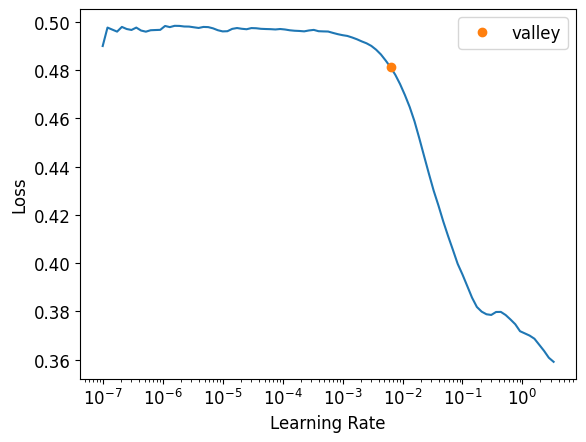

In [45]:
learn.lr_find()

In [52]:
# temporaty bugfix to show training bar
# https://stackoverflow.com/questions/75936184/learn-fine-tune-not-showing-progress-bar-for-each-epoch

from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [74]:
optim.defaults, Adam.__defaults__

({'lr': 0.01,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'maximize': False,
  'foreach': None,
  'capturable': False,
  'differentiable': False,
  'fused': None},
 (0.9, 0.99, 1e-05, 0.01, True))

In [53]:
learn.fit(50)


# plain pytorch and adam
#                  (0.046717324106343466, 0.9423077539151123)

# plain fastai and adam (adam has different defaults in fastai than in pytorch)
# 49	0.045713	0.052635	0.934555	00:06

# plain fastai and adam and Adam,lr=0.01,eps=1e-08,wd=0 (use pytorch defaults in fastai, similar but not identical performance aftr 1 epoch-> not fully identical settings)
# 49	0.038194	0.047352	0.943376

# same, lr 0.005
# 49	0.036489	0.046300	0.941604	00:05

# adaptive learning rate (fit one cycle), Adam,lr=0.01,eps=1e-08,wd=0
# 49	0.024491	0.036311	0.944927	00:05


epoch,train_loss,valid_loss,pearson,time
0,0.249860,0.161909,0.626789,00:05
1,0.186364,0.144062,0.686228,00:05
2,0.160031,0.132197,0.732951,00:05
3,0.143447,0.122537,0.768111,00:04
4,0.131176,0.114710,0.793572,00:05
5,0.121372,0.108624,0.812503,00:04
6,0.113102,0.102871,0.829047,00:05
7,0.106050,0.098513,0.841974,00:04
8,0.100127,0.092880,0.854562,00:05
9,0.094681,0.089960,0.862377,00:05


## Visalize results



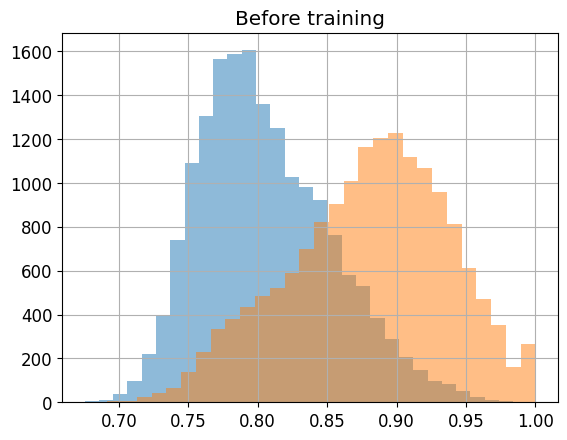

In [63]:
df.groupby(df.score>=0.5).cosine_sim.hist(bins=30,alpha=0.5);
plt.title("Before training");


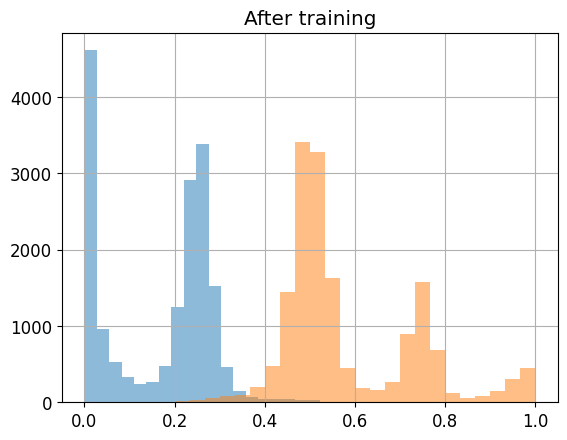

In [78]:
plt.title("After training");


sims=model(e1,e2,matrix)
df["cosine_improved"]=sims.detach()
df.groupby(df.score>=0.5).cosine_improved.hist(bins=30,alpha=0.5);

# expected pattern, close to real scores (0.25 steps)